### This notebook presents the code supporting the analysis of the Master's Thesis 'Multi-City Polish Property Price Prediction using Location Features' by Patrycja Kaminska, student number: 541965, under the supervision of prof. dr. Afra Alishahi.

#### Loading the necessary libraries and the dataset

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
from datetime import datetime, timedelta

# Scikit-learn modules
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Hyperopt for Bayesian Optimization
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.early_stop import no_progress_loss

# SHAP for feature importance
import shap

# Other
from IPython.display import display
from scipy import stats
import joblib
import tensorflow as tf

# XGBoost
import xgboost as xgb

#RF
from sklearn.ensemble import RandomForestRegressor

#MLP
from sklearn.neural_network import MLPRegressor

In [ ]:
dataset = pd.read_csv("kaggle_dataset.csv")

In [162]:
dataset.head()

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,f8524536d4b09a0c8ccc0197ec9d7bde,szczecin,blockOfFlats,63.00,3.0,4.0,10.0,1980.0,53.378933,14.625296,...,0.413,condominium,concreteSlab,NaN,yes,yes,yes,no,yes,415000
1,accbe77d4b360fea9735f138a50608dd,szczecin,blockOfFlats,36.00,2.0,8.0,10.0,NaN,53.442692,14.559690,...,0.205,cooperative,concreteSlab,NaN,no,yes,yes,no,yes,395995
2,8373aa373dbc3fe7ca3b7434166b8766,szczecin,tenement,73.02,3.0,2.0,3.0,NaN,53.452222,14.553333,...,0.280,condominium,brick,NaN,no,no,no,no,no,565000
3,0a68cd14c44ec5140143ece75d739535,szczecin,tenement,87.60,3.0,2.0,3.0,NaN,53.435100,14.532900,...,0.087,condominium,brick,NaN,yes,yes,no,no,yes,640000
4,f66320e153c2441edc0fe293b54c8aeb,szczecin,blockOfFlats,66.00,3.0,1.0,3.0,NaN,53.410278,14.503611,...,0.514,condominium,NaN,NaN,no,no,no,no,no,759000


### Data Pre-Processing

Missing values treatment

In [163]:
dataset.isnull().sum()

id                           0
city                         0
type                     42261
squareMeters                 0
rooms                        0
floor                    34594
floorCount                2383
buildYear                32216
latitude                     0
longitude                    0
centreDistance               0
poiCount                     0
schoolDistance             168
clinicDistance             728
postOfficeDistance         248
kindergartenDistance       207
restaurantDistance         479
collegeDistance           5436
pharmacyDistance           277
ownership                    0
buildingMaterial         77382
condition               146307
hasParkingSpace              0
hasBalcony                   0
hasElevator               9702
hasSecurity                  0
hasStorageRoom               0
price                        0
dtype: int64

Heatmap for missing values

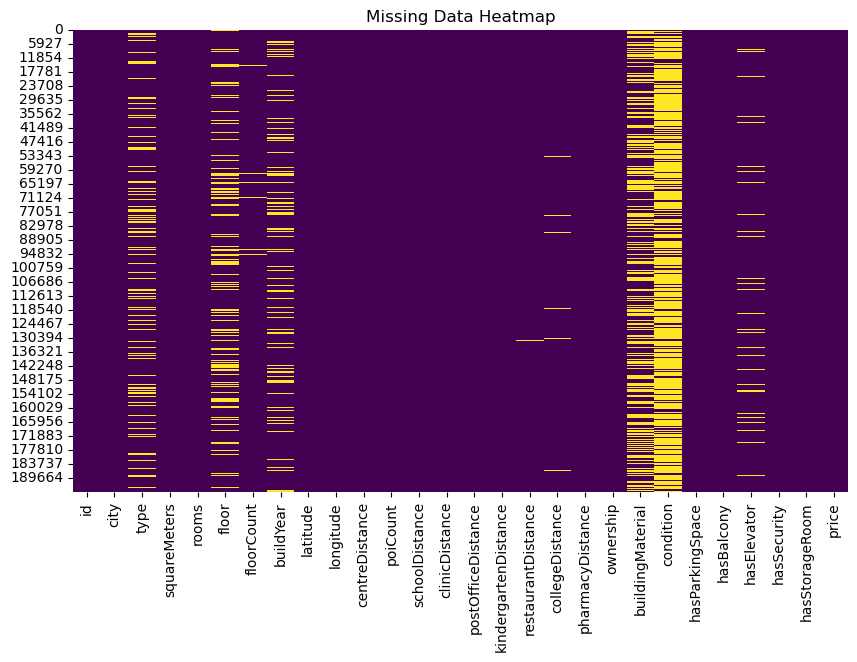

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(dataset.isnull(), cmap="viridis", cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

checking how many missing values per city

In [165]:
missing_per_city = dataset.groupby("city").apply(lambda x: x.isnull().sum())
print(missing_per_city)

             id  city   type  squareMeters  rooms  floor  floorCount  \
city                                                                   
bialystok     0     0    505             0      0    280          16   
bydgoszcz     0     0   2043             0      0   1828         241   
czestochowa   0     0    869             0      0    360          10   
gdansk        0     0   4967             0      0   3757         122   
gdynia        0     0   2273             0      0   1583          28   
katowice      0     0    917             0      0    865         172   
krakow        0     0   4940             0      0   6146         536   
lodz          0     0   1644             0      0   2922         129   
lublin        0     0   1289             0      0   1080          32   
poznan        0     0   1759             0      0   1457         246   
radom         0     0    841             0      0    493          17   
rzeszow       0     0    405             0      0    309        

C:\Users\Patrycja\AppData\Local\Temp\ipykernel_15408\389967018.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_per_city = dataset.groupby("city").apply(lambda x: x.isnull().sum())


In [166]:
missing_total_per_city = dataset.groupby("city").apply(lambda x: x.isnull().sum().sum())
print(missing_total_per_city)

city
bialystok        3812
bydgoszcz       18337
czestochowa      6600
gdansk          40893
gdynia          18925
katowice        10174
krakow          49449
lodz            25446
lublin           9545
poznan          15281
radom            3968
rzeszow          3005
szczecin         8964
warszawa       104576
wroclaw         33413
dtype: int64


C:\Users\Patrycja\AppData\Local\Temp\ipykernel_15408\83085790.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_total_per_city = dataset.groupby("city").apply(lambda x: x.isnull().sum().sum())


### Imputting missing values

feature 'type' - I am imputting it with a new label 'unknown'

In [3]:
dataset["type"] = dataset["type"].fillna("Unknown")

floor and floorcount implemented with median

In [4]:
dataset["floorCount"] = dataset["floorCount"].fillna(dataset["floorCount"].median())
dataset["floor"] = dataset["floor"].fillna(dataset["floorCount"])

checking if the floor is ever bigger than floorcount

In [5]:
invalid_rows_after_imputation = dataset[dataset["floor"] > dataset["floorCount"]]
print(invalid_rows_after_imputation)


Empty DataFrame
Columns: [id, city, type, squareMeters, rooms, floor, floorCount, buildYear, latitude, longitude, centreDistance, poiCount, schoolDistance, clinicDistance, postOfficeDistance, kindergartenDistance, restaurantDistance, collegeDistance, pharmacyDistance, ownership, buildingMaterial, condition, hasParkingSpace, hasBalcony, hasElevator, hasSecurity, hasStorageRoom, price]
Index: []

[0 rows x 28 columns]


feature 'has elevator' - from 1995 all building with more than 4 floors had to have an elevator. and all others will be imputed with median.

In [6]:
dataset['hasElevator'].mode()

0    no
Name: hasElevator, dtype: object

In [7]:
def impute_elevator(row):
    if row['floorCount'] > 4 and row['buildYear'] >= 1995:
        return "yes"
    else:
        return "no"

dataset.loc[dataset['hasElevator'].isnull(), 'hasElevator'] = dataset.loc[dataset['hasElevator'].isnull()].apply(impute_elevator, axis=1)

buildYear - just with median

In [8]:
dataset["buildYear"] = dataset["buildYear"].fillna(dataset["buildYear"].median())

feature all missing POI - imputing with mean for the city its in

In [9]:
city_means = dataset.groupby('city')['collegeDistance'].mean()

dataset['collegeDistance'] = dataset.apply(
    lambda row: city_means[row['city']] if pd.isnull(row['collegeDistance']) else row['collegeDistance'], 
    axis=1
)

In [10]:
city_means = dataset.groupby('city')['schoolDistance'].mean()

dataset['schoolDistance'] = dataset.apply(
    lambda row: city_means[row['city']] if pd.isnull(row['schoolDistance']) else row['schoolDistance'], 
    axis=1
)

In [11]:
city_means = dataset.groupby('city')['clinicDistance'].mean()

dataset['clinicDistance'] = dataset.apply(
    lambda row: city_means[row['city']] if pd.isnull(row['clinicDistance']) else row['clinicDistance'], 
    axis=1
)

In [12]:
city_means = dataset.groupby('city')['schoolDistance'].mean()

dataset['schoolDistance'] = dataset.apply(
    lambda row: city_means[row['city']] if pd.isnull(row['schoolDistance']) else row['schoolDistance'], 
    axis=1
)

In [13]:
city_means = dataset.groupby('city')['postOfficeDistance'].mean()

dataset['postOfficeDistance'] = dataset.apply(
    lambda row: city_means[row['city']] if pd.isnull(row['postOfficeDistance']) else row['postOfficeDistance'], 
    axis=1
)

In [14]:
city_means = dataset.groupby('city')['kindergartenDistance'].mean()

dataset['kindergartenDistance'] = dataset.apply(
    lambda row: city_means[row['city']] if pd.isnull(row['kindergartenDistance']) else row['kindergartenDistance'], 
    axis=1
)

In [15]:
city_means = dataset.groupby('city')['restaurantDistance'].mean()

dataset['restaurantDistance'] = dataset.apply(
    lambda row: city_means[row['city']] if pd.isnull(row['restaurantDistance']) else row['restaurantDistance'], 
    axis=1
)

In [16]:
city_means = dataset.groupby('city')['pharmacyDistance'].mean()

dataset['pharmacyDistance'] = dataset.apply(
    lambda row: city_means[row['city']] if pd.isnull(row['pharmacyDistance']) else row['pharmacyDistance'], 
    axis=1
)

### Feature selection

Dropping these columns cause they have a lot of missing data and they are not impactful for my study

In [17]:
dataset = dataset.drop("buildingMaterial", axis=1)
dataset = dataset.drop("condition", axis=1)
dataset = dataset.drop("id", axis=1)

Distributions in the dataset

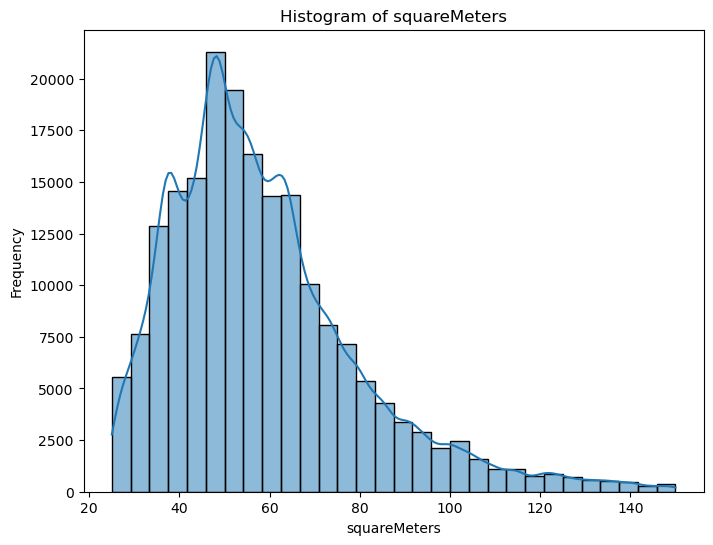

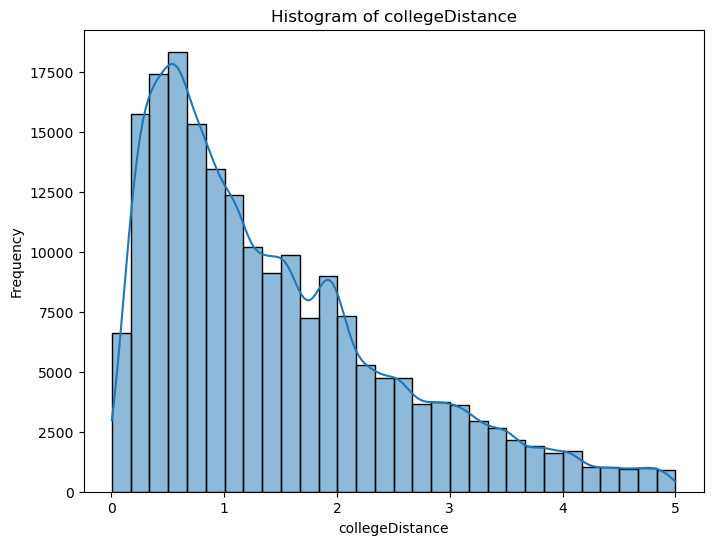

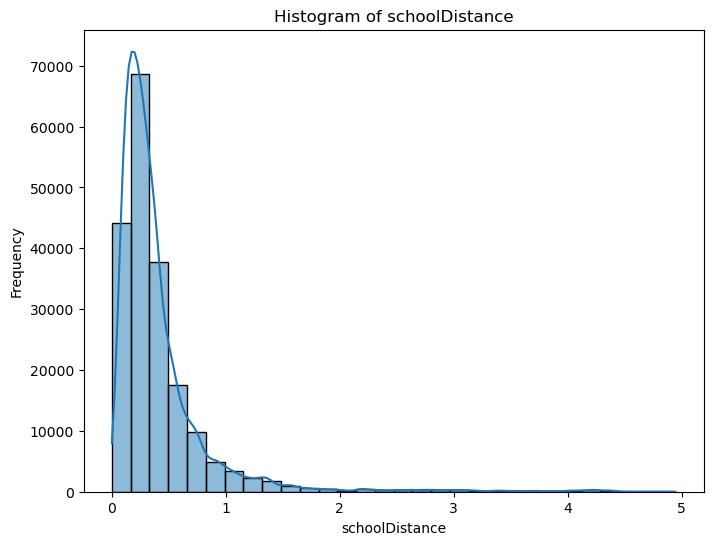

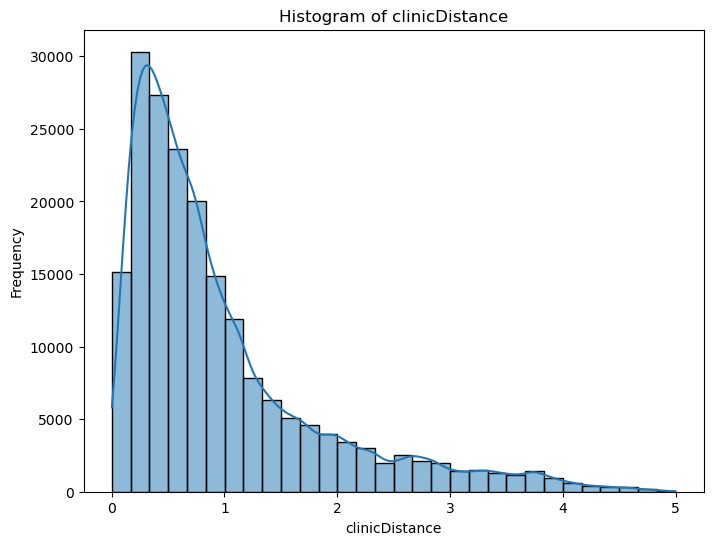

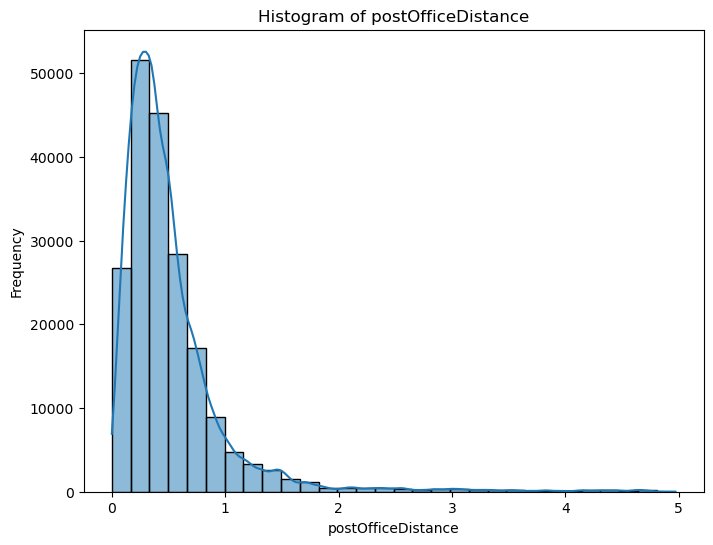

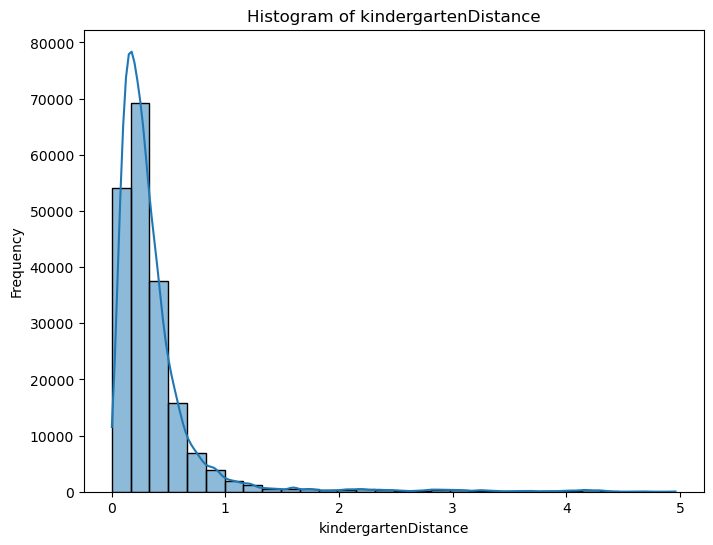

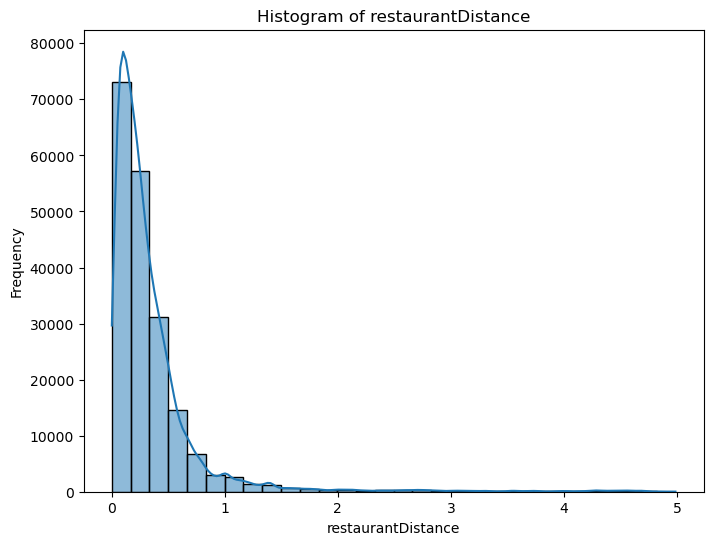

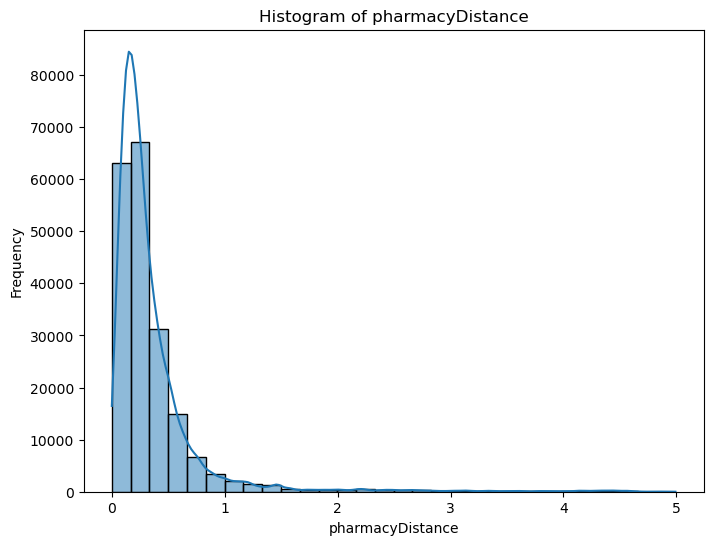

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

relevant_columns = ['squareMeters',
                    'collegeDistance', 'schoolDistance', 'clinicDistance', 'postOfficeDistance',
                    'kindergartenDistance', 'restaurantDistance', 'pharmacyDistance']

for column in relevant_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(dataset[column], kde=True, bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


Log transformation

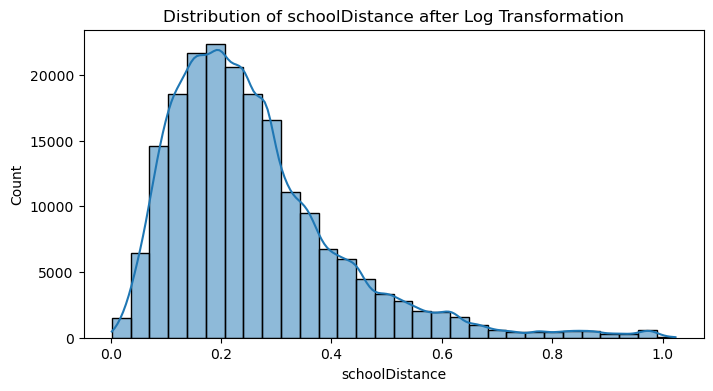

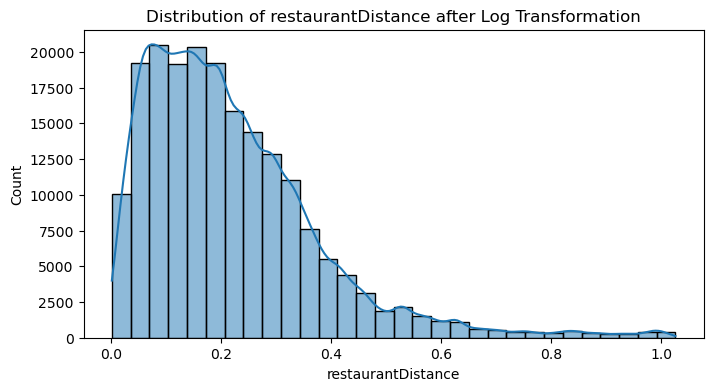

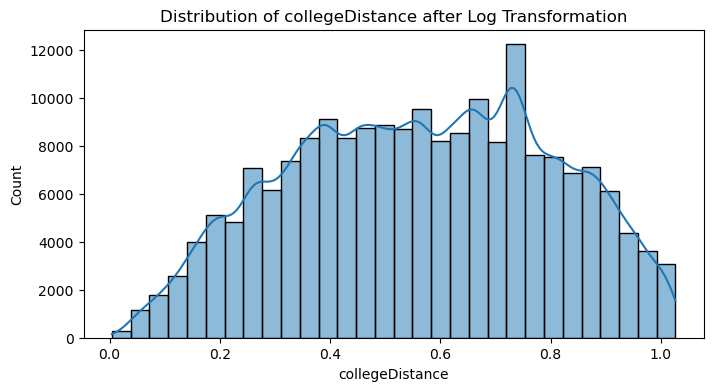

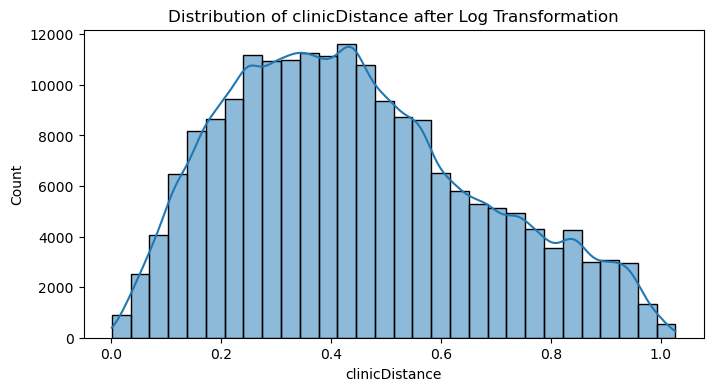

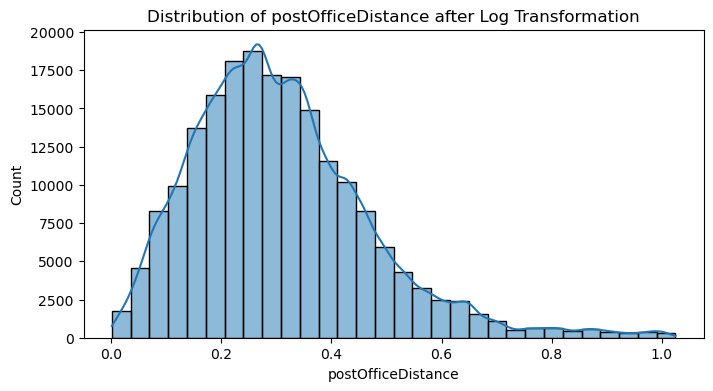

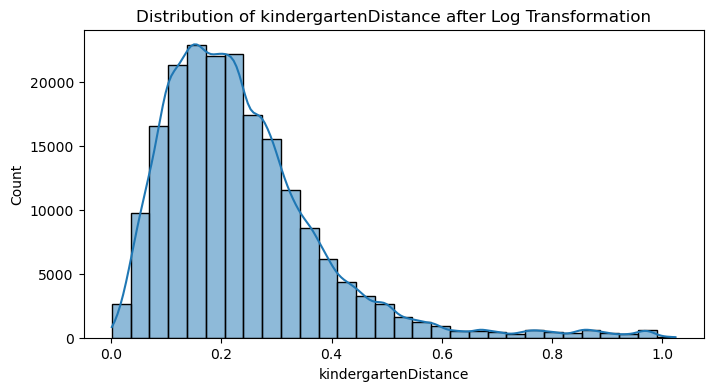

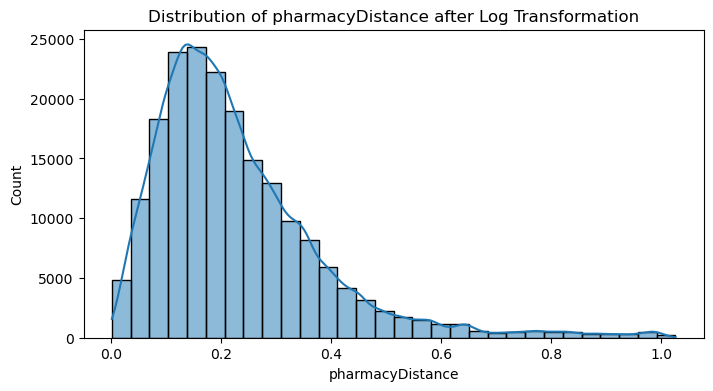

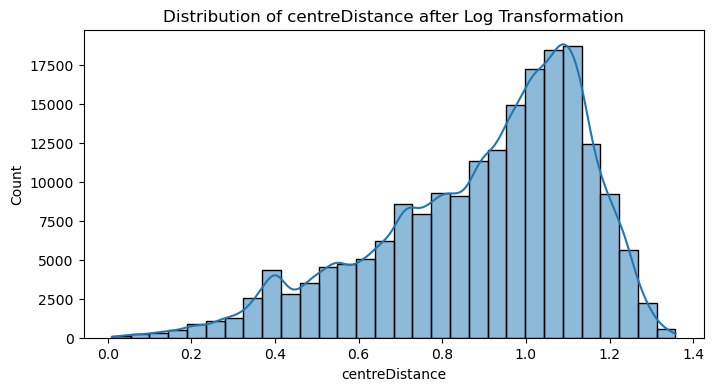

In [ ]:
# List of features
features_to_transform = [
    'schoolDistance', 'restaurantDistance', 'collegeDistance', 'clinicDistance', 
    'postOfficeDistance', 'kindergartenDistance', 'pharmacyDistance', 'centreDistance'
]

# Log transformation
for feature in features_to_transform:
    dataset[feature] = np.log(dataset[feature] + 1)

# Check the transformation
for feature in features_to_transform:
    plt.figure(figsize=(8, 4))
    sns.histplot(dataset[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature} after Log Transformation')
    plt.show()


Box Cox transformation for POI - log transformation didn't work

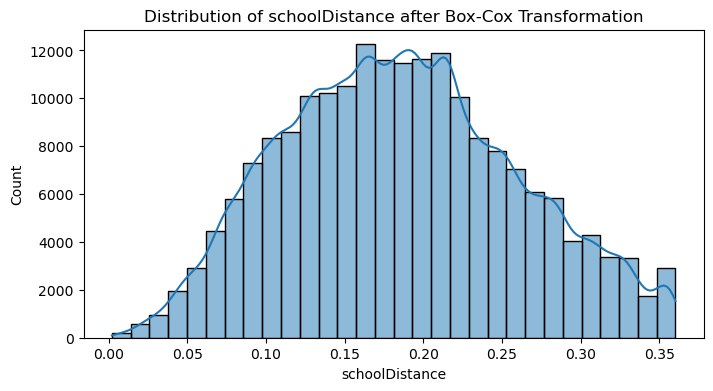

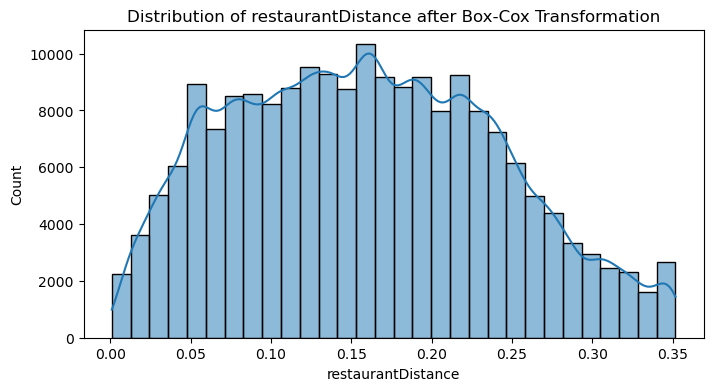

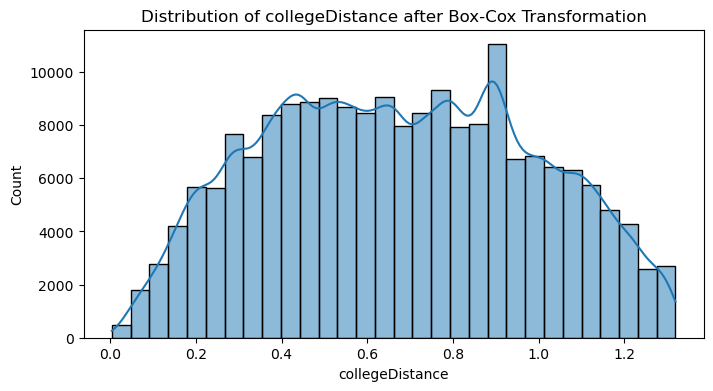

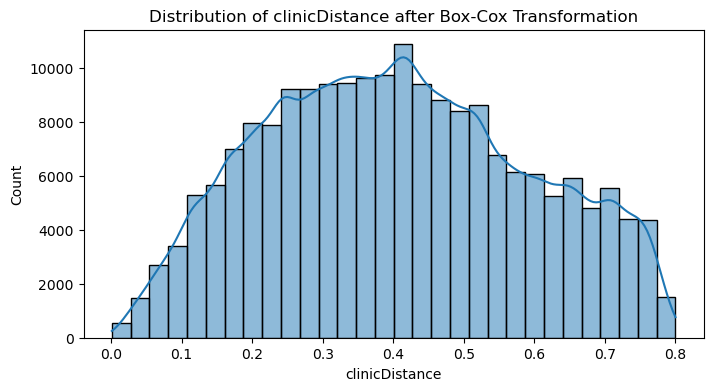

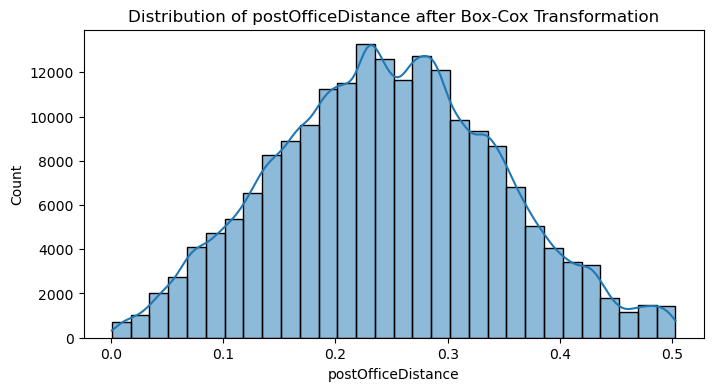

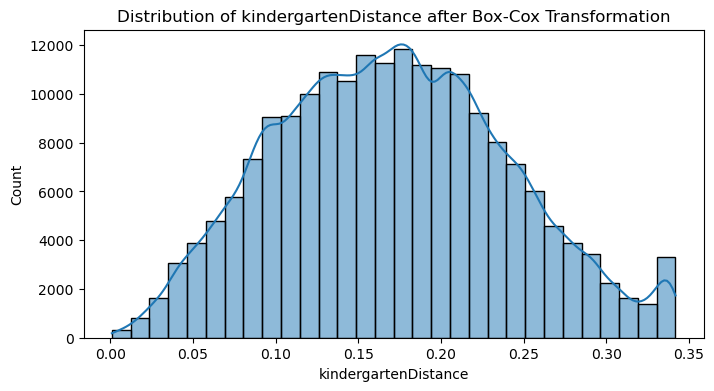

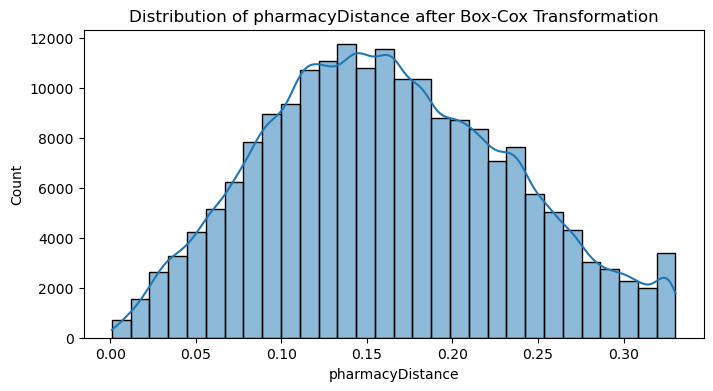

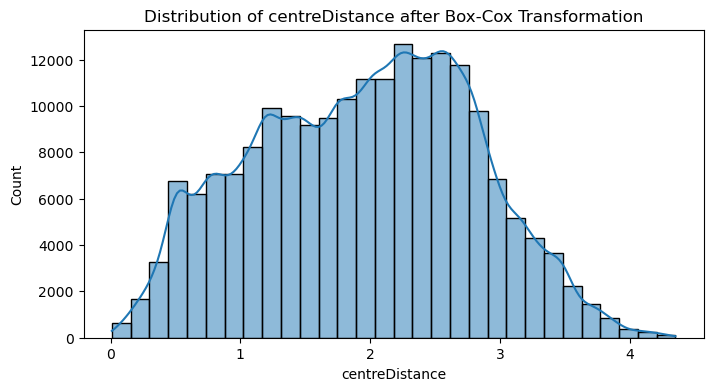

In [ ]:
# List of features for Box-Cox transformation
features_to_transform = [
    'schoolDistance', 'restaurantDistance', 'collegeDistance', 'clinicDistance', 
    'postOfficeDistance', 'kindergartenDistance', 'pharmacyDistance', 'centreDistance'
]

# Box-Cox transformation
for feature in features_to_transform:
    dataset[feature], _ = stats.boxcox(dataset[feature] + 1)

# Check the transformation by visualizing
import matplotlib.pyplot as plt
import seaborn as sns

for feature in features_to_transform:
    plt.figure(figsize=(8, 4))
    sns.histplot(dataset[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature} after Box-Cox Transformation')
    plt.show()



### Encoding categorical features

In [184]:
print(dataset.dtypes)

city                     object
type                     object
squareMeters            float64
rooms                   float64
floor                   float64
floorCount              float64
buildYear               float64
latitude                float64
longitude               float64
centreDistance          float64
poiCount                float64
schoolDistance          float64
clinicDistance          float64
postOfficeDistance      float64
kindergartenDistance    float64
restaurantDistance      float64
collegeDistance         float64
pharmacyDistance        float64
ownership                object
hasParkingSpace          object
hasBalcony               object
hasElevator              object
hasSecurity              object
hasStorageRoom           object
price                     int64
dtype: object


In [185]:
print(dataset['type'].unique())

['blockOfFlats' 'tenement' 'apartmentBuilding' 'Unknown']


In [186]:
print(dataset['ownership'].unique())

['condominium' 'cooperative' 'udział']


Merging udzial and cooperative

In [187]:
ownership_counts = dataset['ownership'].value_counts()

print(ownership_counts)


ownership
condominium    176123
cooperative     19433
udział             12
Name: count, dtype: int64


In [188]:
dataset['ownership'] = dataset['ownership'].replace({'udział': 'cooperative'})

ownership_counts = dataset['ownership'].value_counts()
print(ownership_counts)

ownership
condominium    176123
cooperative     19445
Name: count, dtype: int64


#### Feature Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

# Label Encoding to binary features
binary_columns = ['hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity', 'hasStorageRoom']

for col in binary_columns:
    dataset[col] = label_encoder.fit_transform(dataset[col])

# One-Hot Encoding to nominal features
dataset = pd.get_dummies(dataset, columns=['city', 'type'])

# Binary Encoding to 'ownership'
# "cooperative" as 1 and "condominium" as 0
dataset['ownership'] = label_encoder.fit_transform(dataset['ownership'])

# Verify
print(dataset.head())

   squareMeters  rooms  floor  floorCount  buildYear   latitude  longitude  \
0         63.00    3.0    4.0        10.0     1980.0  53.378933  14.625296   
1         36.00    2.0    8.0        10.0     1994.0  53.442692  14.559690   
2         73.02    3.0    2.0         3.0     1994.0  53.452222  14.553333   
3         87.60    3.0    2.0         3.0     1994.0  53.435100  14.532900   
4         66.00    3.0    1.0         3.0     1994.0  53.410278  14.503611   

   centreDistance  poiCount  schoolDistance  ...  city_poznan  city_radom  \
0        2.676499       9.0        0.096031  ...        False       False   
1        1.342835      16.0        0.176304  ...        False       False   
2        1.763143       9.0        0.177109  ...        False       False   
3        1.393899      32.0        0.130207  ...        False       False   
4        2.032571       1.0        0.152151  ...        False       False   

   city_rzeszow  city_szczecin  city_warszawa  city_wroclaw  type_Un

In [190]:
print(dataset.dtypes)

squareMeters              float64
rooms                     float64
floor                     float64
floorCount                float64
buildYear                 float64
latitude                  float64
longitude                 float64
centreDistance            float64
poiCount                  float64
schoolDistance            float64
clinicDistance            float64
postOfficeDistance        float64
kindergartenDistance      float64
restaurantDistance        float64
collegeDistance           float64
pharmacyDistance          float64
ownership                   int32
hasParkingSpace             int32
hasBalcony                  int32
hasElevator                 int32
hasSecurity                 int32
hasStorageRoom              int32
price                       int64
city_bialystok               bool
city_bydgoszcz               bool
city_czestochowa             bool
city_gdansk                  bool
city_gdynia                  bool
city_katowice                bool
city_krakow   

### Train test split

how many flats in each city after preprocessing

In [3]:
city_counts = dataset.filter(regex='^city_').sum()

print(city_counts)

city_bialystok       2464
city_bydgoszcz       9547
city_czestochowa     2657
city_gdansk         19210
city_gdynia          8164
city_katowice        5284
city_krakow         29026
city_lodz           15300
city_lublin          5704
city_poznan          7705
city_radom           2929
city_rzeszow         1801
city_szczecin        6331
city_warszawa       59246
city_wroclaw        20200
dtype: int64


In [3]:
from sklearn.model_selection import train_test_split

X = dataset.drop(['price'], axis=1)
y = dataset['price']

# Perform stratified split based on the city one-hot encoded columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=dataset.filter(regex='^city_').sum(axis=1), random_state=42)

# Check the city distribution in train and test
train_city_counts = X_train.filter(regex='^city_').sum()
test_city_counts = X_test.filter(regex='^city_').sum()

print("City distribution in the training set:")
print(train_city_counts)

print("\nCity distribution in the test set:")
print(test_city_counts)

City distribution in the training set:
city_bialystok       1929
city_bydgoszcz       7626
city_czestochowa     2099
city_gdansk         15383
city_gdynia          6568
city_katowice        4206
city_krakow         23197
city_lodz           12202
city_lublin          4577
city_poznan          6155
city_radom           2331
city_rzeszow         1426
city_szczecin        5069
city_warszawa       47502
city_wroclaw        16184
dtype: int64

City distribution in the test set:
city_bialystok        535
city_bydgoszcz       1921
city_czestochowa      558
city_gdansk          3827
city_gdynia          1596
city_katowice        1078
city_krakow          5829
city_lodz            3098
city_lublin          1127
city_poznan          1550
city_radom            598
city_rzeszow          375
city_szczecin        1262
city_warszawa       11744
city_wroclaw         4016
dtype: int64


### Normalising the data + outliers

checking for outliers

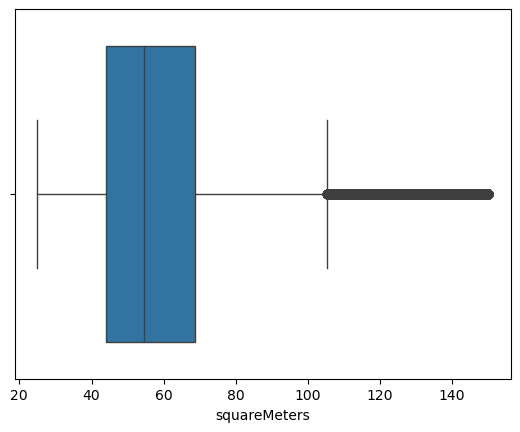

In [ ]:
sns.boxplot(x=dataset["squareMeters"])
plt.show()


This part (the cell below) was adapted from a notebook published by Krzysztof Jamroz on Kaggle under the Apache 2.0 licence called 'Apartment for Sale in Poland - Deep Learning Model'.

In [28]:
lenBefore = len(dataset)

dataset['priceSq'] = dataset['price'] / dataset['squareMeters']

# remove large apartments
dataset = dataset[dataset['squareMeters'] <= 100]

price_cutoff=0.03

# remove very expensive apartments
dataset = dataset[dataset['price'] <= dataset['price'].quantile(1-price_cutoff)]
dataset = dataset[dataset['priceSq'] <= dataset['priceSq'].quantile(1-price_cutoff)]

# remove very cheap 
dataset = dataset[dataset['priceSq'] >= dataset['priceSq'].quantile(price_cutoff)]

dataset = dataset.drop(['priceSq'], axis=1)
lenAfter = len(dataset)
print("Data reduction", lenBefore, '->', lenAfter, '|', str(round(100*(1-lenAfter/lenBefore))) + "%")

Data reduction 195568 -> 169249 | 13%


Standard Scaler for normalizing the data

In [ ]:
X = dataset.drop(columns=['price'])
y = dataset['price']

# continuous features
continuous_cols = X.select_dtypes(include=['float64']).columns

# binary and one-hot encoded features
binary_and_onehot_cols = X.select_dtypes(include=['int64', 'bool']).columns

# StandardScaler for continuous features
scaler = StandardScaler()

# Scale only continuous features
X_scaled = X.copy()
X_scaled[continuous_cols] = scaler.fit_transform(X[continuous_cols])

X_scaled[binary_and_onehot_cols] = X[binary_and_onehot_cols]

In [30]:
X_scaled['price'] = y

### Saving the final (cleaned and ready) dataset

In [ ]:
X_scaled.to_csv('final_dataset.csv', index = False)

### Loading the final dataset

In [ ]:
dataset_full = pd.read_csv('final_dataset.csv')

In [ ]:
print(dataset_full.dtypes)

squareMeters              float64
rooms                     float64
floor                     float64
floorCount                float64
buildYear                 float64
latitude                  float64
longitude                 float64
centreDistance            float64
poiCount                  float64
schoolDistance            float64
clinicDistance            float64
postOfficeDistance        float64
kindergartenDistance      float64
restaurantDistance        float64
collegeDistance           float64
pharmacyDistance          float64
ownership                   int64
hasParkingSpace             int64
hasBalcony                  int64
hasElevator                 int64
hasSecurity                 int64
hasStorageRoom              int64
city_bialystok               bool
city_bydgoszcz               bool
city_czestochowa             bool
city_gdansk                  bool
city_gdynia                  bool
city_katowice                bool
city_krakow                  bool
city_lodz     

Train/Test split

In [ ]:
X = dataset_full.drop(['price'], axis=1)
y = dataset_full['price']

# Perform stratified split based on the city one-hot encoded columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=dataset_full.filter(regex='^city_').sum(axis=1), random_state=42)

# Check the city distribution in train and test
train_city_counts = X_train.filter(regex='^city_').sum()
test_city_counts = X_test.filter(regex='^city_').sum()


In [35]:
print(train_city_counts)
print(test_city_counts)

city_bialystok       1937
city_bydgoszcz       6363
city_czestochowa     1350
city_gdansk         13951
city_gdynia          5774
city_katowice        3430
city_krakow         20247
city_lodz           10967
city_lublin          4397
city_poznan          5750
city_radom           1518
city_rzeszow         1384
city_szczecin        4330
city_warszawa       38521
city_wroclaw        15480
dtype: int64
city_bialystok       466
city_bydgoszcz      1619
city_czestochowa     333
city_gdansk         3421
city_gdynia         1483
city_katowice        883
city_krakow         5051
city_lodz           2761
city_lublin         1080
city_poznan         1470
city_radom           335
city_rzeszow         357
city_szczecin       1018
city_warszawa       9630
city_wroclaw        3943
dtype: int64


In [ ]:
city_counts = dataset_full.filter(regex='^city_').sum()

print(city_counts)

city_bialystok       2403
city_bydgoszcz       7982
city_czestochowa     1683
city_gdansk         17372
city_gdynia          7257
city_katowice        4313
city_krakow         25298
city_lodz           13728
city_lublin          5477
city_poznan          7220
city_radom           1853
city_rzeszow         1741
city_szczecin        5348
city_warszawa       48151
city_wroclaw        19423
dtype: int64


The smallest number of apartments from a city is 1683 (Czestochowa)

Some statistics for each city:

In [ ]:
target_column = 'price'

# Get all one-hot city columns
city_columns = [col for col in dataset_full.columns if col.startswith('city_')]

# Collect min, max, and mean for each city
city_stats = []
for city_col in city_columns:
    city_df = dataset_full[dataset_full[city_col] == 1]
    city_name = city_col.replace('city_', '')
    if not city_df.empty:
        city_stats.append({
            'city': city_name,
            'count': len(city_df),
            'min': city_df[target_column].min(),
            'max': city_df[target_column].max(),
            'mean': city_df[target_column].mean()
        })

# Convert to DataFrame
city_stats_df = pd.DataFrame(city_stats).sort_values(by='mean', ascending=True)
city_stats_df = city_stats_df.reset_index(drop=True)

print(city_stats_df)

           city  count     min      max           mean
0         radom   1853  175000   820000  375330.553157
1   czestochowa   1683  175000   835000  380692.516340
2     bydgoszcz   7982  166000  1000000  418541.149461
3          lodz  13728  176000  1050000  428205.961830
4     bialystok   2403  265000   905000  477639.640033
5      katowice   4313  179000  1390000  498373.810109
6      szczecin   5348  209500  1200000  535009.105086
7        lublin   5477  200000  1200000  544825.151178
8       rzeszow   1741  300000  1325000  554838.314762
9        poznan   7220  220000  1449000  615629.745983
10      wroclaw  19423  269000  1590000  712950.456418
11       gdynia   7257  300000  1590000  717461.768775
12       gdansk  17372  300000  1590000  772020.114437
13       krakow  25298  255000  1590000  801933.021346
14     warszawa  48151  300000  1590000  872467.827397


### Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 5-fold cross-validation on the training set
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation:
cv_r2 = cross_val_score(rf, X_train, y_train, cv=cv, scoring='r2')
cv_mae = cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')

# Print cross-validation scores
print("Cross-validation R2 scores:", cv_r2)
print("Cross-validation MAE scores:", -cv_mae)
print("Cross-validation RMSE scores:", -cv_rmse)

# Mean of the cross-validation metrics
print("\nAverage R2 (Cross-Validation):", np.mean(cv_r2))
print("Average MAE (Cross-Validation):", np.mean(-cv_mae))
print("Average RMSE (Cross-Validation):", np.mean(-cv_rmse))

Cross-validation R2 scores: [0.95473092 0.95415617 0.95383213 0.95573832 0.95640265]
Cross-validation MAE scores: [32950.38811639 33062.75297391 33327.87696022 32878.11867685
 32352.36683334]
Cross-validation RMSE scores: [58718.86364095 58473.50602056 58874.0622136  58053.08077014
 57287.99540602]

Average R2 (Cross-Validation): 0.9549720382431893
Average MAE (Cross-Validation): 32914.30071214279
Average RMSE (Cross-Validation): 58281.50161025456


In [10]:
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Disparate-Group Analysis

In [ ]:
# Get the list of city columns
city_columns = [col for col in X.columns if 'city_' in col]

# Create a dictionary
city_results = {}

# Loop through each city
for city_col in city_columns:
    city_data = dataset_full[dataset_full[city_col] == 1]
    X_city = city_data.drop(columns=['price'])
    y_city = city_data['price']
    y_pred_city = rf.predict(X_city)
    r2_city = r2_score(y_city, y_pred_city)
    mae_city = mean_absolute_error(y_city, y_pred_city)
    rmse_city = np.sqrt(mean_squared_error(y_city, y_pred_city))
    city_results[city_col] = {'R2': r2_city, 'MAE': mae_city, 'RMSE': rmse_city}

# Convert the results into a DataFrame for better visualization
city_results_df = pd.DataFrame(city_results).T
city_results_df.sort_values(by='R2', ascending=False, inplace=True)

# Display the results
print(city_results_df)

                        R2           MAE          RMSE
city_bydgoszcz    0.989666   7910.618200  15413.784072
city_czestochowa  0.987931   7545.722769  14109.737084
city_radom        0.986352   5864.401242  12858.338746
city_gdansk       0.985876  15305.064856  30513.212020
city_gdynia       0.984977  15129.796262  30021.987408
city_lodz         0.984158  10110.981021  19165.244839
city_katowice     0.981212  12583.478580  25119.513040
city_lublin       0.980187  11122.213148  20760.441799
city_krakow       0.977564  19550.177710  37201.818218
city_szczecin     0.977489  11978.766158  23222.635974
city_wroclaw      0.977119  15820.061094  31509.699111
city_warszawa     0.976841  21169.146149  38444.519401
city_rzeszow      0.973158  13090.446371  24791.939399
city_bialystok    0.972677  10537.305790  19866.650282
city_poznan       0.972493  15275.616226  30723.422663


Grid Search Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(random_state=42)

# the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 4, 6, 8, 10],
    'max_features': [1, 2, 4, 6, 8, 10]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit GridSearchCV to train data
grid_search.fit(X_train, y_train)

# best parameters and best score
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("Best Score from Grid Search:", grid_search.best_score_)

# best Random Forest model
best_rf = grid_search.best_estimator_

# Cross-validation
cv_r2 = cross_val_score(best_rf, X_train, y_train, cv=cv, scoring='r2')
cv_mae = cross_val_score(best_rf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(best_rf, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')

# Print cross-validation scores
print("\nCross-validation R2 scores:", cv_r2)
print("Cross-validation MAE scores:", -cv_mae)
print("Cross-validation RMSE scores:", -cv_rmse)

# Mean of the cross-validation metrics
print("\nAverage R2 (Cross-Validation):", np.mean(cv_r2))
print("Average MAE (Cross-Validation):", np.mean(-cv_mae))
print("Average RMSE (Cross-Validation):", np.mean(-cv_rmse))

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best Parameters from Grid Search: {'max_depth': 30, 'max_features': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best Score from Grid Search: -3307803933.332541

Cross-validation R2 scores: [0.95536329 0.9550482  0.95543121 0.95624961 0.95665728]
Cross-validation MAE scores: [33339.27617881 33416.81185418 33501.92947971 33292.16489379
 32761.25661545]
Cross-validation RMSE scores: [58307.29772626 57901.82424449 57845.48846693 57716.81179638
 57120.45307356]

Average R2 (Cross-Validation): 0.9557499162927252
Average MAE (Cross-Validation): 33262.28780438849
Average RMSE (Cross-Validation): 57778.375061523715


In [13]:
# Predict on the test set
y_pred_test_rf = best_rf.predict(X_test)

# Evaluate the performance of the best Random Forest model
r2_test_rf = r2_score(y_test, y_pred_test_rf)
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))

# Print the test set evaluation metrics for the best Random Forest model
print("\nBest Random Forest Test Set R2:", r2_test_rf)
print("Best Random Forest Test Set MAE:", mae_test_rf)
print("Best Random Forest Test Set RMSE:", rmse_test_rf)


Best Random Forest Test Set R2: 0.9622474165288438
Best Random Forest Test Set MAE: 29766.345426787044
Best Random Forest Test Set RMSE: 53428.39009767731


In [14]:
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features=10, n_estimators=200,
                      random_state=42)

Disparate-Group Analysis

In [ ]:
# Get the list of city columns
city_columns = [col for col in X.columns if 'city_' in col]

# Create a dictionary
city_results = {}

# Loop through each city
for city_col in city_columns:
    city_data = dataset_full[dataset_full[city_col] == 1]
    X_city = city_data.drop(columns=['price'])
    y_city = city_data['price']
    y_pred_city = best_rf.predict(X_city)
    r2_city = r2_score(y_city, y_pred_city)
    mae_city = mean_absolute_error(y_city, y_pred_city)
    rmse_city = np.sqrt(mean_squared_error(y_city, y_pred_city))
    city_results[city_col] = {'R2': r2_city, 'MAE': mae_city, 'RMSE': rmse_city}

# Convert the results into a DataFrame for better visualization
city_results_df = pd.DataFrame(city_results).T
city_results_df.sort_values(by='R2', ascending=False, inplace=True)

# Display the results
print(city_results_df)

                        R2           MAE          RMSE
city_bydgoszcz    0.990049   8025.195235  15125.509582
city_radom        0.988195   5690.252007  11958.646759
city_czestochowa  0.987353   7894.951369  14443.568515
city_gdansk       0.986415  15362.625649  29924.578520
city_gdynia       0.986290  14676.078302  28679.272756
city_lodz         0.984715  10392.533861  18825.376550
city_katowice     0.982953  12418.635642  23927.356881
city_lublin       0.980826  11181.274856  20422.777564
city_szczecin     0.979308  11717.848151  22264.557730
city_krakow       0.978421  19640.851759  36484.594281
city_wroclaw      0.978222  16003.800426  30740.807067
city_warszawa     0.976646  21769.163412  38605.631815
city_bialystok    0.974779  10216.100101  19087.224142
city_poznan       0.973944  15310.771653  29902.247408
city_rzeszow      0.973686  12960.984547  24546.841734


### XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation on the training set
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation: Get R2, MAE, and RMSE for each fold
cv_r2 = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='r2')
cv_mae = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')

# Print cross-validation scores
print("Cross-validation R2 scores:", cv_r2)
print("Cross-validation MAE scores:", -cv_mae)
print("Cross-validation RMSE scores:", -cv_rmse)

# Mean of the cross-validation metrics
print("\nAverage R2 (Cross-Validation):", np.mean(cv_r2))
print("Average MAE (Cross-Validation):", np.mean(-cv_mae))
print("Average RMSE (Cross-Validation):", np.mean(-cv_rmse))

Cross-validation R2 scores: [0.89801606 0.89622357 0.894973   0.89827768 0.89766996]
Cross-validation MAE scores: [64648.47594858 64906.74364499 65300.20658293 64695.69270449
 64677.07955254]
Cross-validation RMSE scores: [88133.84504514 87976.7777686  88798.28102161 88007.45902464
 87767.78144247]

Average R2 (Cross-Validation): 0.8970320536022193
Average MAE (Cross-Validation): 64845.63968670275
Average RMSE (Cross-Validation): 88136.82886049224


In [ ]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Now predict on the test set using the best model
y_pred_test = xgb_model.predict(X_test)

# Evaluate on the test set: R2, MAE, and RMSE
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print test set evaluation metrics
print("\nTest Set R2:", r2_test)
print("Test Set MAE:", mae_test)
print("Test Set RMSE:", rmse_test)


Test Set R2: 0.8997437171938036
Test Set MAE: 64264.085463441654
Test Set RMSE: 87067.19417829992


Disparate-Group Analysis

In [ ]:
# Get the list of city columns
city_columns = [col for col in X.columns if 'city_' in col]

# Create a dictionary
city_results = {}

# Loop through each city
for city_col in city_columns:
    city_data = dataset_full[dataset_full[city_col] == 1]
    X_city = city_data.drop(columns=['price'])
    y_city = city_data['price']
    y_pred_city = xgb_model.predict(X_city)
    r2_city = r2_score(y_city, y_pred_city)
    mae_city = mean_absolute_error(y_city, y_pred_city)
    rmse_city = np.sqrt(mean_squared_error(y_city, y_pred_city))
    city_results[city_col] = {'R2': r2_city, 'MAE': mae_city, 'RMSE': rmse_city}

# Convert the results into a DataFrame for better visualization
city_results_df = pd.DataFrame(city_results).T
city_results_df.sort_values(by='R2', ascending=False, inplace=True)

# Display the results
print(city_results_df)

                        R2           MAE          RMSE
city_czestochowa  0.922730  27065.922423  35701.929779
city_gdynia       0.897150  58751.697714  78552.094866
city_gdansk       0.892186  62520.080392  84302.549531
city_bydgoszcz    0.891366  38206.448513  49974.886083
city_radom        0.880382  28533.540854  38067.558054
city_lodz         0.867212  42775.509179  55487.438911
city_krakow       0.863138  69281.077168  91882.728551
city_katowice     0.862586  50218.945615  67933.345892
city_warszawa     0.855179  73413.020254  96136.760367
city_wroclaw      0.833719  62880.667717  84943.355445
city_lublin       0.830034  47777.440341  60805.049108
city_rzeszow      0.820368  48649.096137  64135.180791
city_szczecin     0.820051  50530.641911  65657.636647
city_poznan       0.813466  60018.887028  80007.032882
city_bialystok    0.795444  42102.091279  54358.531336


Grid Search for XGBoost

In [ ]:
# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 4, 6, 8, 10],
    'gamma': [0, 0.1, 0.2]
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Best parameters and best score from GridSearchCV
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Best score from GridSearchCV (neg_mean_squared_error):", grid_search.best_score_)

# Now train the model with the best parameters on the full training set
best_xgb_model = grid_search.best_estimator_

# Perform cross-validation with the best model
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation: Get R2, MAE, and RMSE for each fold
cv_r2 = cross_val_score(best_xgb_model, X_train, y_train, cv=cv, scoring='r2')
cv_mae = cross_val_score(best_xgb_model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(best_xgb_model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')

# Print cross-validation scores
print("\nCross-validation R2 scores:", cv_r2)
print("Cross-validation MAE scores:", -cv_mae)  # Since 'neg_mean_absolute_error' returns negative values
print("Cross-validation RMSE scores:", -cv_rmse)  # Since 'neg_root_mean_squared_error' returns negative values

# Mean of the cross-validation metrics
print("\nAverage R2 (Cross-Validation):", np.mean(cv_r2))
print("Average MAE (Cross-Validation):", np.mean(-cv_mae))
print("Average RMSE (Cross-Validation):", np.mean(-cv_rmse))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters found by GridSearchCV: {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 200}
Best score from GridSearchCV (neg_mean_squared_error): -3708731841.6306505

Cross-validation R2 scores: [0.95061569 0.94801195 0.95117863 0.95140793 0.95246288]
Cross-validation MAE scores: [32599.41207302 33383.54720216 32674.85741668 32598.59022341
 32091.29964237]
Cross-validation RMSE scores: [61329.76731675 62268.79088141 60542.3229705  60826.67125358
 59820.49481955]

Average R2 (Cross-Validation): 0.9507354152336595
Average MAE (Cross-Validation): 32669.54131152801
Average RMSE (Cross-Validation): 60957.609448358955


In [ ]:
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Now predict on the test set using the best model
y_pred_test = best_xgb_model.predict(X_test)

# Evaluate on the test set: R2, MAE, and RMSE
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print test set evaluation metrics
print("\nTest Set R2:", r2_test)
print("Test Set MAE:", mae_test)
print("Test Set RMSE:", rmse_test)


Test Set R2: 0.9569102497629381
Test Set MAE: 30399.046516802067
Test Set RMSE: 57080.23315312894


Disparate-Group Analysis

In [ ]:
# Get the list of city columns
city_columns = [col for col in X.columns if 'city_' in col]

# dictionary to store results
city_results = {}

# Loop through each city
for city_col in city_columns:
    city_data = dataset_full[dataset_full[city_col] == 1]
    X_city = city_data.drop(columns=['price'])
    y_city = city_data['price']
    y_pred_city = best_xgb_model.predict(X_city)
    r2_city = r2_score(y_city, y_pred_city)
    mae_city = mean_absolute_error(y_city, y_pred_city)
    rmse_city = np.sqrt(mean_squared_error(y_city, y_pred_city))
    city_results[city_col] = {'R2': r2_city, 'MAE': mae_city, 'RMSE': rmse_city}

# Convert the results into a DataFrame for better visualization
city_results_df = pd.DataFrame(city_results).T
city_results_df.sort_values(by='R2', ascending=False, inplace=True)

# Display the results
print(city_results_df)

                        R2           MAE          RMSE
city_gdynia       0.987398  13093.427113  27496.694120
city_gdansk       0.987390  14285.598389  28831.011308
city_czestochowa  0.985567   8405.149426  15429.733918
city_radom        0.985466   6706.369283  13269.104650
city_bydgoszcz    0.984774  11149.153973  18709.352572
city_katowice     0.983772  11505.899878  23345.445662
city_lodz         0.981806  11564.527157  20539.178933
city_lublin       0.981302  10714.030739  20167.738916
city_krakow       0.979869  17259.208843  35239.587647
city_wroclaw      0.979643  14678.727361  29721.361357
city_warszawa     0.978986  18484.586547  36620.596027
city_szczecin     0.978594  11100.715051  22645.501228
city_poznan       0.977403  13446.102482  27846.788351
city_rzeszow      0.976040  10057.199239  23423.291987
city_bialystok    0.975913   9217.551212  18653.124584


### MLP

Bayesian Optimization

From now on, the outputs are not visible under the cells with code. That is due to the fact that these parts were run on an external server with more power. However, the output for the Bayesian Optimization can be seen in the file 'output_bayesian_optimization.txt'. Moreover, the results for the iterations are stored in the 'bayesian_optimization_results.csv' file.

In [ ]:
# Reset index and convert to NumPy
X_train = X_train.reset_index(drop=True).values
y_train = y_train.reset_index(drop=True).values
assert len(X_train) == len(y_train), "X_train and y_train should have the same length."

# Define hyperparameter space
space = {
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(150, 100, 50), (50, 100, 150), (100, 100, 100)]),
    'activation': hp.choice('activation', ['relu']),
    'solver': hp.choice('solver', ['adam', 'lbfgs']),
    'alpha': hp.choice('alpha', [0.01, 0.001, 0.0001, 0.00001]),
    'max_iter': hp.choice('max_iter', [500, 1000, 1500, 2000]),
    'learning_rate': hp.choice('learning_rate', ['constant', 'adaptive']),
    'early_stopping': hp.choice('early_stopping', [True, False])
}

# Define objective function
def objective(params):
    mlp_model = MLPRegressor(
        hidden_layer_sizes=params['hidden_layer_sizes'],
        activation=params['activation'],
        solver=params['solver'],
        alpha=params['alpha'],
        max_iter=params['max_iter'],
        learning_rate=params['learning_rate'],
        early_stopping=params['early_stopping'],
        random_state=42
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, val_index in cv.split(X_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        mlp_model.fit(X_fold_train, y_fold_train)
        y_pred = mlp_model.predict(X_fold_val)
        mse = mean_squared_error(y_fold_val, y_pred)
        mse_scores.append(mse)

    mean_mse = np.mean(mse_scores)
    return {
        'loss': mean_mse,
        'loss_variance': np.var(mse_scores),
        'status': STATUS_OK
    }

# Run optimization
trials = Trials()
start_time = time.time()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    early_stop_fn=no_progress_loss(20)
)

# Decode best hyperparameters
space_choices = {
    'hidden_layer_sizes': [(150, 100, 50), (50, 100, 150), (100, 100, 100)],
    'activation': ['relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.01, 0.001, 0.0001, 0.00001],
    'max_iter': [500, 1000, 1500, 2000],
    'learning_rate': ['constant', 'adaptive'],
    'early_stopping': [True, False]
}

decoded_best = {key: space_choices[key][best[key]] for key in best}

# Save results
results = []
for trial in trials.trials:
    trial_data = {
        'Trial': trial['tid'],
        'Hidden Layer Sizes': trial['misc']['vals']['hidden_layer_sizes'],
        'Activation': trial['misc']['vals']['activation'],
        'Solver': trial['misc']['vals']['solver'],
        'Alpha': trial['misc']['vals']['alpha'],
        'Max Iter': trial['misc']['vals']['max_iter'],
        'Learning Rate': trial['misc']['vals']['learning_rate'],
        'Early Stopping': trial['misc']['vals']['early_stopping'],
        'Mean MSE': trial['result']['loss']
    }
    results.append(trial_data)

df_results = pd.DataFrame(results)
df_results.to_csv('bayesian_optimization_results.csv', index=False)

# Output results
print("\nDecoded Best Hyperparameters:")
for key, value in decoded_best.items():
    print(f"{key}: {value}")

print("\nBayesian Optimization Results:")
for trial in trials.trials:
    print(f"Trial {trial['tid']}:")
    print("Hyperparameters:", trial['misc']['vals'])
    print("Loss (Mean MSE):", trial['result']['loss'])
    print("Status:", trial['result']['status'])
    print("-" * 50)

# Best trial info
best_trial = min(trials.trials, key=lambda x: x['result']['loss'])
print("\nBest Trial:")
print("Hyperparameters:", best_trial['misc']['vals'])
print("Mean MSE:", best_trial['result']['loss'])

Again, the code was run on an external server. Therefore, the output can be seen in the file 'output_best_mlp.txt' and not under the following cell.

In [ ]:
mlp_model_2 = MLPRegressor(hidden_layer_sizes=(150, 100, 50), activation = 'relu', alpha= 0.001, early_stopping= False, learning_rate= 'constant', max_iter = 2000, solver = 'lbfgs', random_state=42)

# Perform 5-fold cross-validation on the training set
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation: Get R2, MAE, and RMSE for each fold
cv_r2 = cross_val_score(mlp_model_2, X_train, y_train, cv=cv, scoring='r2')
cv_mae = cross_val_score(mlp_model_2, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(mlp_model_2, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')

# Print cross-validation scores
print("Cross-validation R2 scores:", cv_r2)
print("Cross-validation MAE scores:", -cv_mae)
print("Cross-validation RMSE scores:", -cv_rmse)

# Mean of the cross-validation metrics
print("\nAverage R2 (Cross-Validation):", np.mean(cv_r2))
print("Average MAE (Cross-Validation):", np.mean(-cv_mae))
print("Average RMSE (Cross-Validation):", np.mean(-cv_rmse))

mlp_model_2.fit(X_train, y_train)

# Predict on the test set
y_pred_test = mlp_model_2.predict(X_test)

# Evaluate on the test set: R2, MAE, and RMSE
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print test set evaluation metrics
print("\nTest Set R2:", r2_test)
print("Test Set MAE:", mae_test)
print("Test Set RMSE:", rmse_test)

# Get the list of city columns (those that are one-hot encoded)
city_columns = [col for col in X.columns if 'city_' in col]

# Create a dictionary to store results
city_results = {}

# Loop through each city
for city_col in city_columns:
    city_data = dataset[dataset[city_col] == 1]
    X_city = city_data.drop(columns=['price'])
    y_city = city_data['price']
    y_pred_city = mlp_model_2.predict(X_city)
    r2_city = r2_score(y_city, y_pred_city)
    mae_city = mean_absolute_error(y_city, y_pred_city)
    rmse_city = np.sqrt(mean_squared_error(y_city, y_pred_city))
    city_results[city_col] = {'R2': r2_city, 'MAE': mae_city, 'RMSE': rmse_city}

# Convert the results into a DataFrame for better visualization
city_results_df = pd.DataFrame(city_results).T
city_results_df.sort_values(by='R2', ascending=False, inplace=True)

# Display the results
print(city_results_df)

### SHAP analysis

The SHAP analysis was also run on an external server. The output can be seen in the file 'shap_analysis_output.txt' and the values are stored in a pickle 'shap_values_subset.pkl'.

In [ ]:
rf = RandomForestRegressor(
    max_depth=30,
    max_features=10,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Reconstruct city from one-hot encoding
X_temp = X.copy()
X_temp['city'] = X_temp[[col for col in X.columns if col.startswith('city_')]].idxmax(axis=1)

# Sample n rows per city
rows_per_city = 1000
X_shap_subset = (
    X_temp.groupby('city', group_keys=False)
    .apply(lambda x: x.sample(n=min(rows_per_city, len(x)), random_state=42), include_groups=False)
)

X_shap_subset = X_shap_subset.drop(columns='city', errors='ignore')

X_train = X_train.astype(float)
X_shap_subset = X_shap_subset.astype(float)

start_time = time.time()

print("Starting SHAP computation")

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_shap_subset)
end_time = time.time()

# Calculate the time (in mins)
elapsed_time_sec = end_time - start_time
elapsed_time_min = elapsed_time_sec / 60

print(f"SHAP computation completed in {elapsed_time_min:.2f} minutes")

joblib.dump(shap_values, "shap_values_subset.pkl")

print("SHAP analysis complete.")

Generating the necessary plots with descriptions

In [2]:
import joblib


In [3]:
shap_values = joblib.load("shap_values_subset.pkl")

Creating the bar plot

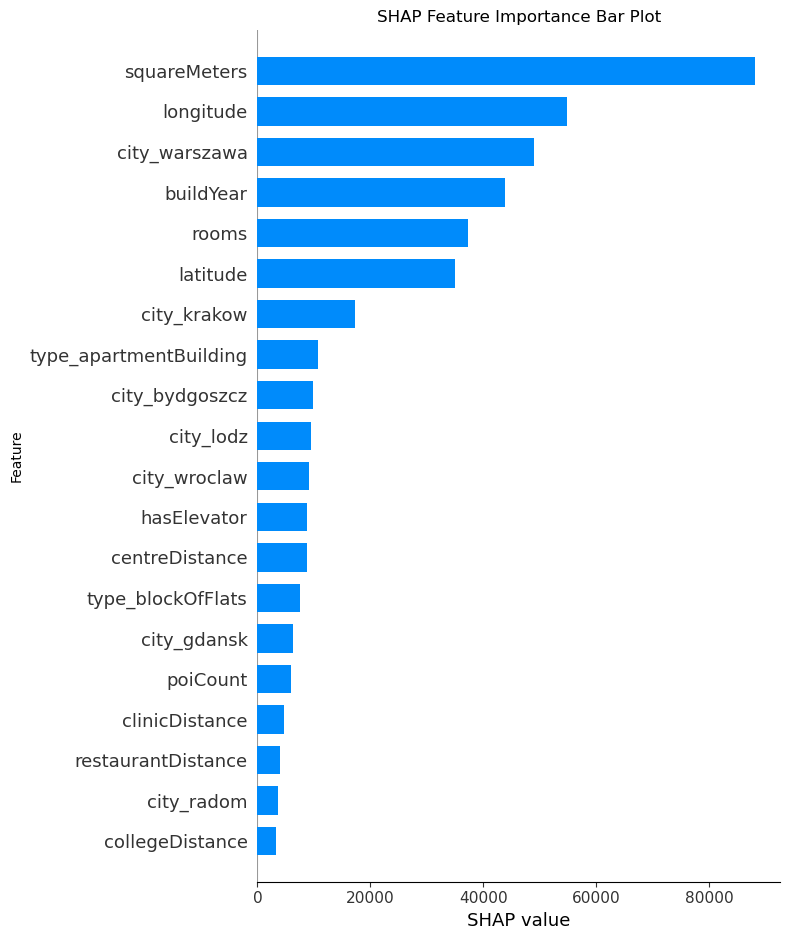

In [ ]:
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_shap_subset, plot_type="bar", show=False)
plt.title("SHAP Feature Importance Bar Plot")
plt.xlabel("SHAP value")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("shap_summary_bar_labeled.png")
plt.show()


Creating the beeswarm plot

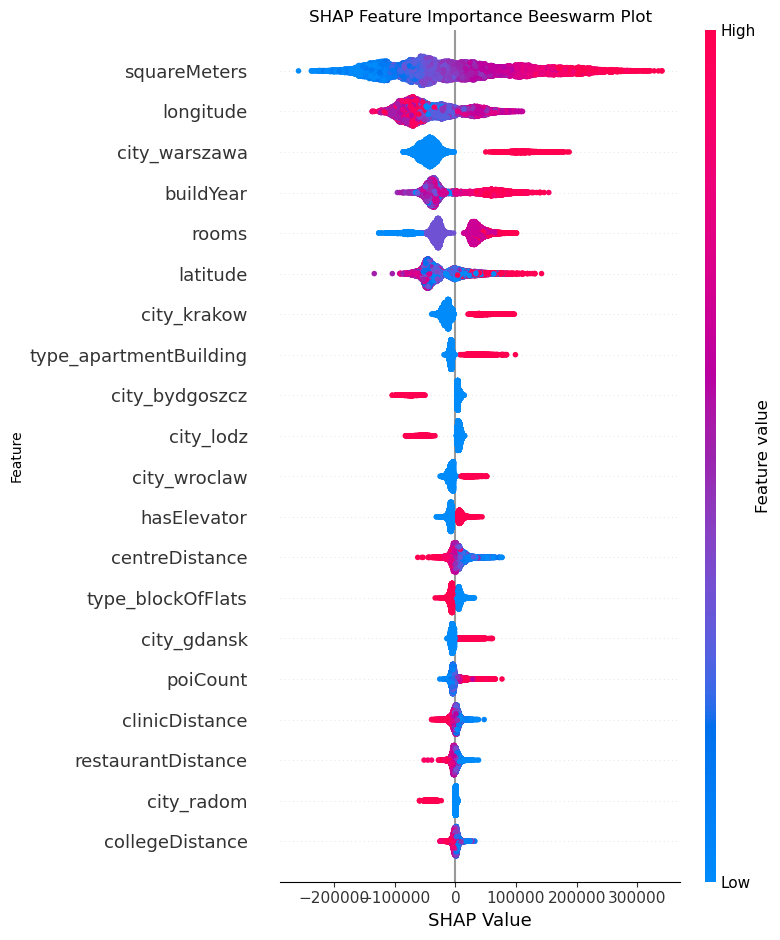

In [9]:
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_shap_subset, show = False)
plt.title("SHAP Feature Importance Beeswarm Plot")
plt.xlabel("SHAP Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("shap_summary_beeswarm_labeled.png")
plt.show()